# DEA Notebook 

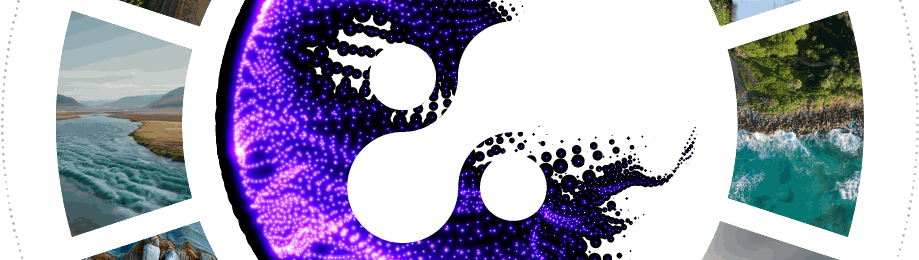

### [DEA](https://dea.destine.eu/web) is a Content creation service and no-code platform for DestinE storytelling and data visualization

# Generate Video from WMS Layer

This notebook guides you through the process of generating an `.mp4` video from a WMS (Web Map Service) layer.

The resulting video can be used within the DEA platform for dynamic map visualisations, fully compatible with features such as zooming, rotating the globe, and temporal navigation.

> **_NOTE:_** You can replace the suggested WMS layer with any layer of your choice, either from DEA or from any other provider offering a compliant WMS endpoint.

---

## WMS to MP4 – Flow Overview
An `.mp4` video can be generated from a series of `.png` images, which are retrieved through server requests to a WMS layer.  
Therefore, only **WMS layers with time support** (i.e., multiple available dates) are suitable for generating such videos.


Here’s the step-by-step workflow: <br>
<br>
🌐 Select a WMS Layer (with <Dimension name="time"> support) <br>
└── The layer must support multiple time values (time series) <br>

📅 Retrieve all available time steps <br>
└── Parse WMS Capabilities or use predefined date ranges <br>

🖼️ Download one image per time step using WMS GetMap requests <br>
└── Each image represents a map snapshot at a specific time <br>

💾 Save the images locally as sequential PNG files <br>
└── Files are named and sorted by date <br>

🎞️ Combine the images into an MP4 video <br>
└── Tools like imageio or ffmpeg are used to encode the video <br>

🗺️ Visualise the video inside the DEA viewer <br>
└── Take advantage of globe rotation, zoom, and timeline interaction <br>
<!-- <img src="diagram_flux_wms2mp4.png" width="300px"> -->

---

## Notebook Agenda

1. **Load Dependencies**
2. **List all available layers in the DEA portfolio (all/filtered)**
3. **Set WMS Parameters for video**
4. **Download WMS Images Over Time**
5. **Create MP4 Video from WMS Frames**
6. **Preview the Result**


# 1. Load Dependencies

### Install pre-requirements

In [11]:
!pip install ffmpeg-python imageio

### Import necesary python library

In [17]:
from PIL import Image
from io import BytesIO
import os
import datetime as dt
import ffmpeg
from pathlib import Path
import shutil
import requests
import glob

# 2. List All Available Layers in the DEA Portfolio

You can list all available layers included in the DEA portfolio.  
To understand which layer to use in the WMS request and check its time availability, the following information will be printed for each layer:

- **Title**: A human-readable name that helps you identify the dataset (e.g., as shown in the DEA web interface).
- **iso8601**: Indicates the time coverage and resolution of the dataset in the format:  
  `<start>/<stop>/<resolution>`  
  where:
  - `start`: beginning of the time series (ISO 8601 format)
  - `stop`: end of the time series
  - `resolution`: time step between two data entries (e.g., `P1D` = 1 day, `PT1H` = 1 hour)
- **Name**: The internal identifier of the layer used in the WMS request — required to retrieve each frame of your video.
- **Workspace**: The logical group or collection to which the layer belongs.

### Define the base URL for the API and execute the get connection:

In [49]:
base_url = "https://dea.destine.eu/api/wmsLayers"

response = requests.get(base_url)
data_list = response.json()

### List the DEA available WORKSPACES 

In [50]:
print("📦 Available Workspaces:")
workspaces = {data.get("workspace") for data in data_list if data.get("workspace")}
for ws in sorted(workspaces):
    print(f"- {ws}")

📦 Available Workspaces:
- cams
- cmems
- destine
- ecmwf
- era5
- eumetsat
- swarm


### Filter data based on WORKSPACE

In [51]:
for data in data_list:
    if data.get("workspace") == 'destine':
        print(f"Title: {data['title']},\n Subitle: {data['subtitle']},\n iso8601: {data['iso8601']}, \n Name: {data['name']}")
        print("")

Title: Time-mean sea ice thickness (m),
 Subitle: 1 year of DestinE Climate DT,
 iso8601: 2025-01-01T00:00:00Z/2025-12-31T00:00:00Z/P1D, 
 Name: avg_sithick_DE_D_CDT

Title: Time-mean sea surface temperature (K),
 Subitle: 1 year of DestinE Climate DT,
 iso8601: 2025-01-01T00:00:00Z/2025-12-31T00:00:00Z/P1D, 
 Name: avg_tos_DE_D_CDT

Title: 2 metre dewpoint temperature (K),
 Subitle: 10 years of DestinE Climate DT,
 iso8601: 2020-01-05T00:00:00Z/2029-12-30T00:00:00Z/P7D, 
 Name: d2m_DE_W_CDT

Title: Relative humidity (%),
 Subitle: 2 weeks of DestinE Climate DT,
 iso8601: 2025-09-06T00:00:00Z/2025-09-21T23:00:00Z/PT1H, 
 Name: r_DE_H_CDT

Title: Snow depth (m of water equivalent),
 Subitle: 10 years of DestinE Climate DT,
 iso8601: 2020-01-05T00:00:00Z/2029-12-30T00:00:00Z/P7D, 
 Name: sd_DE_W_CDT

Title: Surface net short-wave solar radiation (J/m2),
 Subitle: 1 month of DestinE Climate DT,
 iso8601: 2025-09-07T00:00:00Z/2025-10-07T23:00:00Z/PT1H, 
 Name: ssr_DE_H_CDT

Title: Surface 

### Filter data based on TITLE 
(It's useful if you have found the data on the service UI)

In [52]:
for data in data_list:
    if "10 m wind speed (m/s)" in data.get("title", ""): # "precipitation"
        print(f"Title: {data['title']},\n Subitle: {data['subtitle']},\n iso8601: {data['iso8601']}, \n Name: {data['name']}, \n Workspace: {data['workspace']}")

        print("")
        # break

Title: 10 m wind speed (m/s),
 Subitle: 1 month of DestinE Climate DT,
 iso8601: 2025-09-07T00:00:00Z/2025-10-07T23:00:00Z/PT1H, 
 Name: windspeed_DE_H_CDT, 
 Workspace: destine

Title: ERA5 10 m wind speed (m/s),
 Subitle: Reanalysis from 1940 to 2025-4,
 iso8601: 1940-01-01T00:00:00Z/2025-04-27T00:00:00Z/P7D, 
 Name: windspeed_era5, 
 Workspace: era5



### Check Data Availability

**NOTE:** very important to define the correct period in the request!

In [40]:
for data in data_list:
    if "windspeed_DE_H_CDT" in data.get("name", ""):
        iso8601 = data.get('iso8601', "")
        start_raw, stop_raw, res = iso8601.split("/")
        start = dt.datetime.fromisoformat(start_raw.replace("Z", ""))
        stop = dt.datetime.fromisoformat(stop_raw.replace("Z", ""))
        
        print(f"Start date: {start.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"End date: {stop.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Resolution: {res}")

Start date: 2025-09-07 00:00:00
End date: 2025-10-07 23:00:00
Resolution: PT1H


# 3. Set WMS Parameters for video

Now that you have the list of available layers, you can fill in all necessary parameters to define the WMS URL for the "GetMap" request.

**NOTE**: We add the "world_50" layer to have the boundaries of countries worldwide on our frames. 

In [41]:
bbox = "-180,-90,180,90"
crs = "EPSG:4326"
layers = "windspeed_DE_H_CDT,world_50"
workspace = "destine"
out_format = "image/png"


# Define time range and intervals
start_date = dt.datetime(2025, 9, 6)
end_date = dt.datetime(2025, 9, 10)
time_step = dt.timedelta(hours=12) # get one frame each 12 hours

# Define the output folder to store the WMS images
var_name = layers.split(',')[0]
timestamp = dt.datetime.now().strftime("%Y%m%dT%H%M%S")
output_folder = f"map_images_{var_name}_{timestamp}" 

print(f"Start date: {start_date}")
print(f"End date: {end_date}")
print(f"")
print(f"Output folder: {output_folder}")

Start date: 2025-09-06 00:00:00
End date: 2025-09-10 00:00:00

Output folder: map_images_windspeed_DE_H_CDT_20250609T080246


### Define WMS server URL

In [42]:
# #wms_url = "https://mini.dea.destine.eu/geo/geoserver/destine/wms"
# http://141.94.2.70/geo/geoserver/destine/wms?Time=2024-05-01T00:01:00.00Z&transparent=true&format=image%2Fjpeg&service=WMS&version=1.1.1&request=GetMap&styles=&layers=t2m_DE_H_CDT,world_50&bbox=-180,-90,180,90&width=3840&height=2160&srs=EPSG%3A4326
wms_url = f"https://dea.destine.eu/geo/geoserver/{workspace}/wms"
print(f"WMS address: {wms_url}")

WMS address: https://dea.destine.eu/geo/geoserver/destine/wms


# 4. Download WMS Images Over Time

We are now ready to run the core cell, which queries the WMS API and saves one image per time step in the specified output folder.

Each image corresponds to a specific time value from the available time series, and will later be used to generate the video.


In [43]:
basename = os.path.abspath(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Loop through the time range and retrieve map data
current_date = start_date
while current_date <= end_date:
    # Construct the request URL
    time_str = current_date.isoformat() + "Z"
    params = {
        "REQUEST": "GetMap",
        "bbox": bbox,
        "CRS": crs,
        "layers": layers,
        "format": out_format,
        "TIME": time_str,
        "WIDTH": 1920, #3840
        "HEIGHT": 1080, #2160
        "transparent": "true"
    }
    
    print(f"time_str: {time_str} wmsUrl: {wms_url} params: {params}")
    response = requests.get(wms_url, params=params)

    if response.status_code == 200:
        # Save the map data as an image
        image = Image.open(BytesIO(response.content))
        image.save(f"{output_folder}/map_{time_str}.png")
    
    # Increment the current date by the time step
    current_date += time_step

time_str: 2025-09-06T00:00:00Z wmsUrl: https://dea.destine.eu/geo/geoserver/destine/wms params: {'REQUEST': 'GetMap', 'bbox': '-180,-90,180,90', 'CRS': 'EPSG:4326', 'layers': 'windspeed_DE_H_CDT,world_50', 'format': 'image/png', 'TIME': '2025-09-06T00:00:00Z', 'WIDTH': 1920, 'HEIGHT': 1080, 'transparent': 'true'}
time_str: 2025-09-06T12:00:00Z wmsUrl: https://dea.destine.eu/geo/geoserver/destine/wms params: {'REQUEST': 'GetMap', 'bbox': '-180,-90,180,90', 'CRS': 'EPSG:4326', 'layers': 'windspeed_DE_H_CDT,world_50', 'format': 'image/png', 'TIME': '2025-09-06T12:00:00Z', 'WIDTH': 1920, 'HEIGHT': 1080, 'transparent': 'true'}
time_str: 2025-09-07T00:00:00Z wmsUrl: https://dea.destine.eu/geo/geoserver/destine/wms params: {'REQUEST': 'GetMap', 'bbox': '-180,-90,180,90', 'CRS': 'EPSG:4326', 'layers': 'windspeed_DE_H_CDT,world_50', 'format': 'image/png', 'TIME': '2025-09-07T00:00:00Z', 'WIDTH': 1920, 'HEIGHT': 1080, 'transparent': 'true'}
time_str: 2025-09-07T12:00:00Z wmsUrl: https://dea.dest

# 5. Create MP4 Video from WMS Frames

Now that all frames have been saved, we can assemble them into an `.mp4` video.

### Define the video settings:
- **Frame rate**: number of frames per second (e.g., `6`). The higher the faster the video.
- **Images path**: the folder containing all PNG images generated at the previous step. The list uses a wildcard (e.g., `map_*.png`)
- **Output**: name and path to save the final `.mp4` file (e.g., `wind_speed.mp4`)

In [44]:
fps = 6  # frames per second

images_path = basename + "/*.png"
output_path = basename + "/output.mp4"

images_path = str(Path(basename) / "map_*.png")
output_path = str(Path(basename) / "wind_speed.mp4")


print(f"Input images path: {images_path}")
print(f"Output video path: {output_path}")
print("")

images = glob.glob(images_path)  # es: "/home/.../map_images_windspeed_DE_H_CDT/map_*.png"
print(f"Found {len(images)} images:")
for img in images:
    print("-", img)

Input images path: /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_*.png
Output video path: /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/wind_speed.mp4

Found 9 images:
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-08T12:00:00Z.png
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-09T00:00:00Z.png
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-10T00:00:00Z.png
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-06T12:00:00Z.png
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-07T12:00:00Z.png
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-09T12:00:00Z.png
- /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/map_2025-09-06T00:00:00Z.png
- /home/jovyan/dea-lab/wms2m

### Execute the video generation command (ffmpeg library)

In [45]:
(
    ffmpeg
    .input(images_path, pattern_type='glob', framerate=fps)
    .output(output_path, vcodec='libx264', pix_fmt='yuv420p')
    .run()
)

print(f"Video saved to {output_path}")

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Video saved to /home/jovyan/dea-lab/wms2mp4/map_images_windspeed_DE_H_CDT_20250609T080246/wind_speed.mp4


[out#0/mp4 @ 0x55fe6ba70a40] video:1143kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.084124%
frame=    9 fps=1.1 q=-1.0 Lsize=    1144kB time=00:00:01.00 bitrate=9375.0kbits/s speed=0.122x    
[libx264 @ 0x55fe6ba72480] frame I:1     Avg QP:19.56  size:389165
[libx264 @ 0x55fe6ba72480] frame P:2     Avg QP:22.70  size:147946
[libx264 @ 0x55fe6ba72480] frame B:6     Avg QP:22.75  size: 80858
[libx264 @ 0x55fe6ba72480] consecutive B-frames: 11.1%  0.0%  0.0% 88.9%
[libx264 @ 0x55fe6ba72480] mb I  I16..4:  7.3% 59.0% 33.7%
[libx264 @ 0x55fe6ba72480] mb P  I16..4:  6.2% 32.1%  7.1%  P16..4: 25.3% 18.8%  9.6%  0.0%  0.0%    skip: 1.0%
[libx264 @ 0x55fe6ba72480] mb B  I16..4:  2.5% 12.0%  2.4%  B16..8: 18.9% 15.1%  5.3%  direct: 9.4%  skip:34.4%  L0:45.8% L1:44.1% BI:10.0%
[libx264 @ 0x55fe6ba72480] 8x8 transform intra:66.8% inter:72.0%
[libx264 @ 0x55fe6ba72480] coded y,uvDC,uvAC intra: 83.2% 97.7% 93.5% inter: 46.5% 58.4% 39.6%
[libx264 @ 0x55fe6ba72480]

# 6. Preview the Results

###  From the Browser

To preview the video directly from the notebook environment:

1. Navigate to the output folder you defined.
2. Right-click on the generated `.mp4` file.
3. Select **"Open in a new browser window"** to play the video.

<div>
    <center>
        <img src="open_mp4_in_browser.png" width="400" alt="Open the video in the browser"/>
    </center>
</div>

---

###  From the DEA Platform

To use the video inside the DEA viewer:

1. Navigate to the output folder you defined.
2. Right-click on the `.mp4` video file and choose **"Download"**.
3. Upload the video to DEA as a new **Asset**.
4. Select the video asset in your **slide** to enable preview on the globe.


<div>
    <center>
        <img src="add_video_on_map.png" width="400" alt="Add video in the story"/>
    </center>
</div>